In [1]:
import pandas as pd
import numpy as np
df1 = pd.read_excel("Documents\OR_internship.xlsx")
df = df1.head(100)

In [2]:
demand = dict(zip(list(range(0,len(df['Demand']))),df["Demand"]))
price = dict(zip(list(range(0,len(df['Demand']))),2*df['Storage cost(MAD)']))
cost = dict(zip(list(range(0,len(df['Demand']))),df['Storage cost(MAD)']))
volumes = dict(zip(list(range(0,len(df['Demand']))),df['Volume (ml)']))

In [6]:
import random

# Set the random seed for reproducibility
random.seed(42)

# Set the size of the problem
N = len(df['Demand'])  # Update with your desired size

# Generate random values for alpha
alphab = {(i, j): round(random.uniform(0, 1), 2) if i != j else 0 for i in range(N) for j in range(N)}

# Print the generated alpha dictionary
print(alphab)


{(0, 0): 0, (0, 1): 0.64, (0, 2): 0.03, (0, 3): 0.28, (0, 4): 0.22, (0, 5): 0.74, (0, 6): 0.68, (0, 7): 0.89, (0, 8): 0.09, (0, 9): 0.42, (0, 10): 0.03, (0, 11): 0.22, (0, 12): 0.51, (0, 13): 0.03, (0, 14): 0.2, (0, 15): 0.65, (0, 16): 0.54, (0, 17): 0.22, (0, 18): 0.59, (0, 19): 0.81, (0, 20): 0.01, (0, 21): 0.81, (0, 22): 0.7, (0, 23): 0.34, (0, 24): 0.16, (0, 25): 0.96, (0, 26): 0.34, (0, 27): 0.09, (0, 28): 0.1, (0, 29): 0.85, (0, 30): 0.6, (0, 31): 0.81, (0, 32): 0.73, (0, 33): 0.54, (0, 34): 0.97, (0, 35): 0.38, (0, 36): 0.55, (0, 37): 0.83, (0, 38): 0.62, (0, 39): 0.86, (0, 40): 0.58, (0, 41): 0.7, (0, 42): 0.05, (0, 43): 0.23, (0, 44): 0.29, (0, 45): 0.08, (0, 46): 0.23, (0, 47): 0.1, (0, 48): 0.28, (0, 49): 0.64, (0, 50): 0.36, (0, 51): 0.37, (0, 52): 0.21, (0, 53): 0.27, (0, 54): 0.94, (0, 55): 0.65, (0, 56): 0.61, (0, 57): 0.17, (0, 58): 0.73, (0, 59): 0.16, (0, 60): 0.38, (0, 61): 0.99, (0, 62): 0.64, (0, 63): 0.56, (0, 64): 0.68, (0, 65): 0.84, (0, 66): 0.78, (0, 67): 0.23

In [20]:
import numpy as np
import xpress as xp
import time
import matplotlib.pyplot as plt

def generate_random_values(N):
    price = {i: 2 * np.random.randint(1, 101) for i in range(N)}
    demand = {i: np.random.randint(1, 16) for i in range(N)}
    alpha = np.random.rand(N, N)
    cost = {i: np.random.randint(1, 101) for i in range(N)}
    volumes = {i: np.random.randint(100, 1001) for i in range(N)}
    return price, demand, alpha, cost, volumes

def solve_problem(N):
    # Create the problem
    prob = xp.problem()

    # Decision variables
    n = 100
    x = np.array([xp.var(vartype=xp.binary, name=f'x_{i}') for i in range(1, n + 1)])
    u = np.array([xp.var(vartype=xp.integer, lb=0, name=f'u_{i}') for i in range(1, n + 1)])
    z = np.array([[xp.var(vartype=xp.binary, name=f'z_{i}_{j}') for j in range(1, n + 1)] for i in range(1, n + 1)])

    prob.addVariable(x, u, z)

    # Parameters
    K_T = 10000
    d = np.array(list(demand.values()))
    w = np.array(list(volumes.values()))
    alpha = np.array(list(alphab.values()))  # Random values for alpha
    c = np.array(list(cost.values())) # Random values for cost
    p = 2 * c
    C = 1.2 * K_T * np.dot(w, d)  # Random values for C
    M = 1000000000
    delta = 0.7
        # Objective function
    prob.setObjective(xp.Sum(K_T * p[i] * d[i] * x[i] for i in range(n)) +xp.Sum(K_T * p[i] * xp.Sum(
    delta*alpha[j, i] * d[j] * (x[i] - z[i, j]) for j in range(n) if j != i)for i in range(n))
    - xp.Sum(c[i] * u[i] for i in range(n)),sense=xp.maximize)

    # Constraints
    prob.addConstraint(xp.Sum(w[i] * u[i] for i in range(n)) <= C)
    for i in range(n):
        prob.addConstraint(u[i] <= M * x[i])
        prob.addConstraint(
            u[i]>= K_T * d[i] * x[i]+ K_T*xp.Sum(delta*alpha[j, i] * d[j] * (x[i] - z[i, j]) for j in range(n) if j != i) )
        for j in range(n):
            if j != i:
                prob.addConstraint(z[i, j] <= x[i])
                prob.addConstraint(z[i, j] <= x[j])
                prob.addConstraint(z[i, j] >= x[i] + x[j] - 1)
                prob.addConstraint(z[j, i] == z[i, j]) 

    # Solve the problem
    prob.solve()

    # Print non-zero variable values as lists
    print("x:")
    for i in range(n):
        if prob.getSolution(x[i]) > 0:
            print(f"x_{i}: {prob.getSolution(x[i])}")

    print("u:")
    for i in range(n):
        if prob.getSolution(u[i]) > 0:
            print(f"u_{i}: {prob.getSolution(u[i])}")

    print("z:")
    for i in range(n):
        for j in range(n):
            if prob.getSolution(z[i][j]) > 0:
                print(f"z_{i}_{j}: {prob.getSolution(z[i][j])}")
    return prob.getObjVal()

    

In [ ]:
N = 130
np.random.seed(0) 
start_time = time.time()
objective_value = solve_problem(N)
end_time = time.time()
execution_time = end_time - start_time
execution_times.append(execution_time)
print(f"Objective Value (N={N}): {objective_value}")
print("exec times",execution_times)

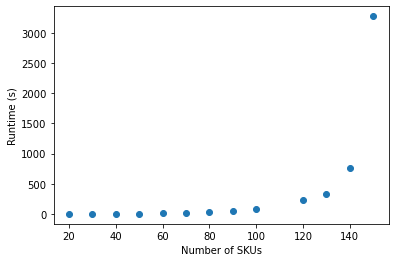

In [25]:
import matplotlib.pyplot as plt

runtime = [0.42102622985839844, 0.9150559902191162, 2.3501505851745605, 3.2532296180725098, 12.493886709213257, 17.333451747894287, 34.87989664077759, 41.07705354690552, 87.91926693916321, 224.46654272079468, 330.90917086601257, 769.1396324634552, 3278.3439977169037]
size = [20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 130, 140, 150]
plt.scatter(size,runtime)
plt.xlabel("Number of SKUs")
plt.ylabel("Runtime (s)")
plt.show()